In [15]:
#imprt libraries
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
import json
#use rasters to calculate ndwi, mndwi, ndbi, ndvi and so on indeces
import rasterio

In [16]:
#OAuth credentials for data acces
with open("log.json") as e:
    data = json.load(e);

CLIENT_ID = data["client_id"]
CLIENT_SECRET = data["client_secret"]
print(CLIENT_ID)
print(CLIENT_SECRET)

sh-1d5fd29b-8c4d-4580-9caf-aa69d6c5076b
4kbJMPkxvjMTVHlRroEKL8RJniGk89SX


In [17]:
#set up user credentials 
client = BackendApplicationClient(client_id = CLIENT_ID)
oauth = OAuth2Session(client=client)

#acquire oatuh token for data acces
token = oauth.fetch_token(
    token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
    client_secret = CLIENT_SECRET,
    include_client_id = True
)

In [18]:
#define image parameters
bbox = [28.0626,45.446 , 28.1626,45.546]
start_date = "2020-06-01"
end_date = "2020-08-31"
collection_id = "sentinel-2-l2a"

In [19]:
# evalscript
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { id: 'default',
              bands: 3 }
  };
}

function evaluatePixel(sample) {
  return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
}
"""

# request body/payload
json_request = {
    'input': {
        'bounds': {
            'bbox': bbox,
            'properties': {
                'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'
            }
        },
        'data': [
            {
                'type': 'S2L2A',
                'dataFilter': {
                    'timeRange': {
                        'from': f'{start_date}T00:00:00Z',
                        'to': f'{end_date}T23:59:59Z'
                    },
                    'mosaickingOrder': 'leastCC',
                },
            }
        ]
    },
    'output': {
        'width': 1024,
        'height': 1024,
        'responses': [
            {
                'identifier': 'default',
                'format': {
                    'type': 'image/jpeg',
                }
            }
        ]
    },
    'evalscript': evalscript
}

In [20]:
url_request = "https://sh.dataspace.copernicus.eu/api/v1/process"
headers_request = {
    "Authorization": f"Bearer {token['access_token']}"
}

# Send the request
response = oauth.post(url_request, headers=headers_request, json=json_request)

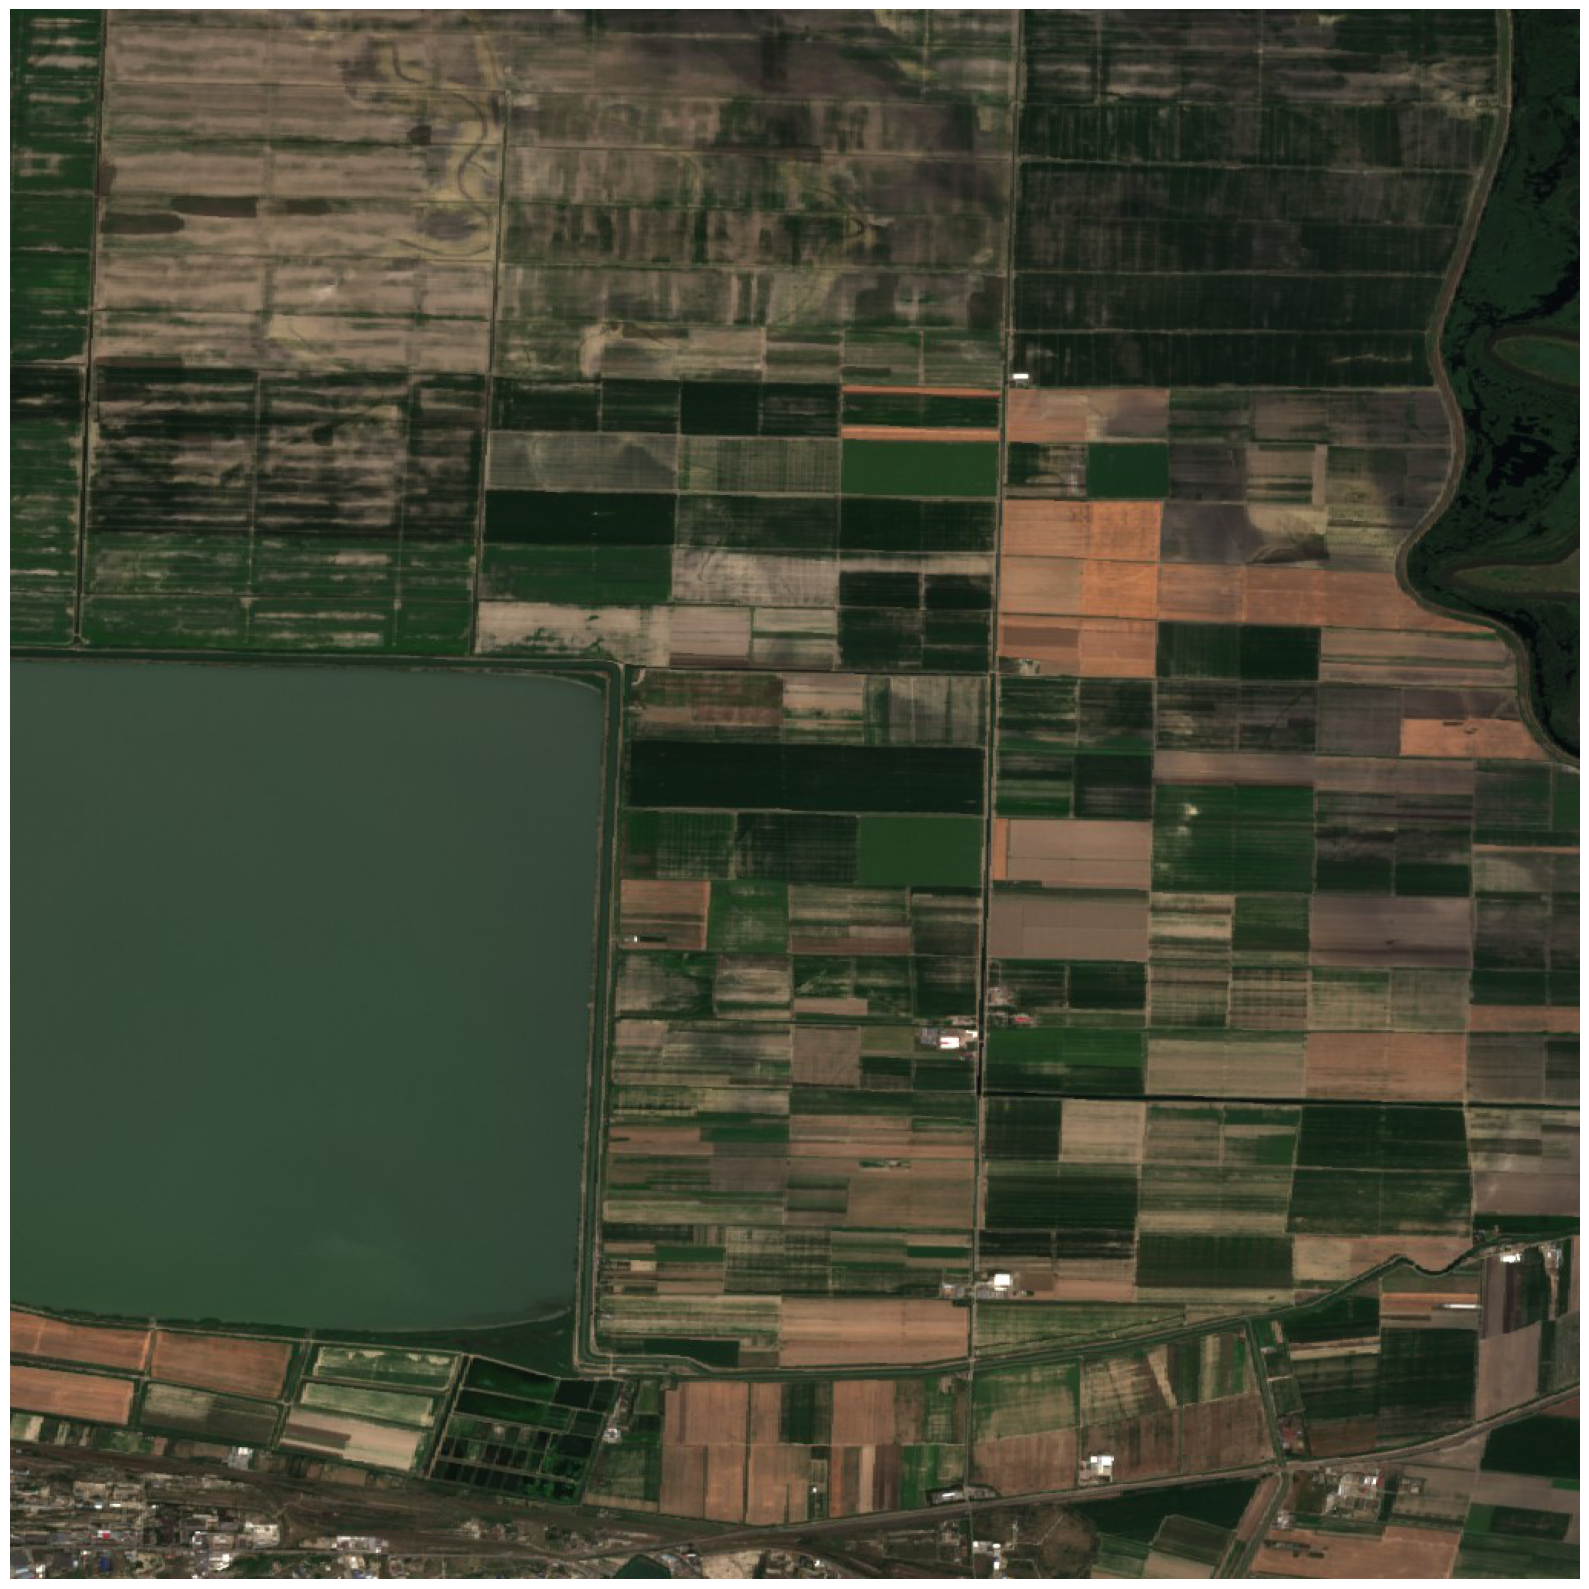

In [21]:
# read the image as numpy array
image_arr = np.array(Image.open(io.BytesIO(response.content)))

# plot the image for visualization
plt.figure(figsize=(16,16))
plt.axis('off')
plt.tight_layout()
plt.imshow(image_arr)